In [1]:
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering, OPTICS
from sklearn.metrics import rand_score, v_measure_score

# СИСТЕМА ОЦЕНИВАНИЯ СХОЖЕСТИ ФОРМЫ ТРЕХМЕРНЫХ МОДЕЛЕЙ

Воспользуемся гистограммами из архива https://drive.google.com/file/d/1JnnbtKOj0H_8wQu1TnhnrWXXKPr_NIB7/view?usp=sharing

Подготовим данные. Уберем лишнюю информацию из лейблов и возьмем гистограммы с одинаковыми интервалами для кластеризации.

In [2]:
labels = pd.read_csv('labels.csv', index_col='model')
labels.type = labels.type.apply(lambda x: x.split('.')[0])
labels

,type
model,
b5025746-e58f-4696-837c-5b21808b7ae9,Torus
30a730ca-c466-4e8c-b00b-bf7b317495e2,Cone
7d0c7362-1e8d-4008-b444-cdf111e06ce9,Sphere
d58d68a4-7acb-48d8-96bd-71f1eca1affe,Sphere
df907d43-7c4f-4ccd-9350-0d84c41dba54,Cube
...,...
e194b0ba-7565-4919-b108-f288dd73852d,Cone
255e1024-5967-4247-9de9-b595403f6bc5,Cone
4289a105-141e-4857-b1d8-831d933a29a3,Cylinder


In [3]:
X = []
y = []

for histogram_filename in os.listdir('histograms'):
    X.append([])
    with open('histograms/' + histogram_filename, 'r') as f:
        histogram = json.load(f)
    for data in histogram['histogram_data']:
        if data['intervals'] == 8:
            X[-1].extend(data['data'])
    y.append(labels.loc[histogram_filename[:-5], 'type'])

X = np.array(X)
y = np.array(y)

Изобразим получившиеся вектора. 

In [4]:
X_tsne = TSNE(n_components=2).fit_transform(X)

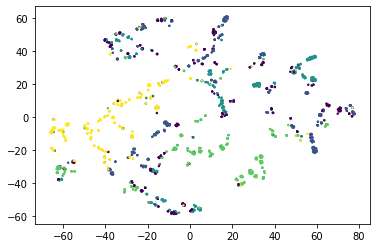

In [5]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 2, pd.factorize(y)[0])
plt.show()

Кажется, кластеризовать будет сложно.

Попробуем несколько алгоритмов с разными параметрами и будем оптимизировать их по Rand score и V-measure - хорошим метрикам оценивания кластеризации.

In [6]:
model = AgglomerativeClustering(n_clusters=5, affinity='l2', linkage='complete')
y_pred = model.fit_predict(X)
print(rand_score(y, y_pred), v_measure_score(y, y_pred))

0.6402198468573151 0.11103595687318644


In [7]:
model = KMeans(n_clusters=5)
y_pred = model.fit_predict(X)
print(rand_score(y, y_pred), v_measure_score(y, y_pred))

0.6654941734623953 0.07421220487423369


In [8]:
model = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', n_neighbors=26)
y_pred = model.fit_predict(X)
print(rand_score(y, y_pred), v_measure_score(y, y_pred))

0.7217015522828565 0.2034945415952617


Лучший, хоть и плохой, результат дала спектральная кластеризация с графом ближайших соседей. 